# Confidence bands and envelopes

Confidence intervals are good for visualising uncertainty of a particular parameter.
However, sometimes we are interested in the uncertainty of many parameters or in the uncertainty of a function:

* how a predictor $f:[0,1]\to\mathbb{R}$ depends on the training set
* how a ROC curve $\mathrm{Roc}:[0,1]\to[0,1]$ depends on the test set
* where a quantile-quantile plot $\mathrm{qq}:[0,1]\to[0,1]$ should lie if the null hypothesis is satisfied

To address this issue, we can compute confidence intervals for individual inputs and then draw the corresponding envelope. Such an envelope is called a **pointwise confidence band**. 
Alternatively, we might be able to find an envelope where the function is expected to be in $95\%$ fraction of cases. 
Such an envelope is called a **simultaneous confidence band**.
For obvious reasons, simultaneous confidence bands are much wider than pointwise bands.  

Confidence envelopes can be devised also for visualising uncertainty of several parameters at once. For instance, showing the uncertainty of mean and variance estimators in the same figure. 

In the following we explain how to compute pointwise confidence intervals for the examples listed above.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame
from pandas import concat

from tqdm.notebook import trange
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. What is a quantile-quantile plot?

We can compare data sources by comparing samples taken from them. 
For instance, we can compute the mean value and variance for both samples and compare them.
This gives a nice overview but discards a lot of information about the exact shapes of the distributions of the samples.

Quantile-quantile plots are the best way to compare samples from two different distributions. In brief, if `x` and `y` are sample vectors of the same size coming from two different distributions then plotting `x.sort()` against `y.sort()` produces a qq-plot.

By sorting the values, we are effectively computing the quantiles of the distribution. Hence, the plot visualises how the corresponding quantiles are related. If `x` and `y` come from the same distribution, the resulting graph should ideally follow the line $x = y$. Due to random fluctuations, the plot deviates from a straight line. 
In the following, we take the frequentist viewpoint and ask how big deviations occur on average if $x$ and $y$ come from the same distribution.

### Quantile-quantile plot for samples from a uniform distribution 

In [2]:
df = [None] * 3

n = 10
x = rnd.uniform(size=n)
y = rnd.uniform(size=n)
df[0]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(label = 'n={}'.format(n))

df[0]

,x,y,label
0,0.007969,0.036505,n=10
1,0.273886,0.399884,n=10
2,0.279485,0.442664,n=10
3,0.290723,0.452327,n=10
4,0.337410,0.574606,n=10
5,0.468346,0.583280,n=10
6,0.568288,0.639711,n=10
7,0.741150,0.675790,n=10
8,0.917091,0.741341,n=10
9,0.990478,0.835215,n=10


In [3]:
n = 100
x = rnd.uniform(size=n)
y = rnd.uniform(size=n)
df[1]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(label = 'n={}'.format(n))

n = 1000
x = rnd.uniform(size=n)
y = rnd.uniform(size=n)
df[2]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(label = 'n={}'.format(n))

mdisplay([head(df[0]), head(df[1]), head(df[2])], ['n=10', 'n=100', 'n=1000'])
df = pd.concat(df, ignore_index=True)

n=10,n=100,n=1000
x,y,label
0.007969,0.036505,n=10
0.273886,0.399884,n=10
0.279485,0.442664,n=10
0.290723,0.452327,n=10
0.337410,0.574606,n=10
x,y,label
0.003071,0.011747,n=100
0.022759,0.019820,n=100
0.044264,0.021828,n=100


/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


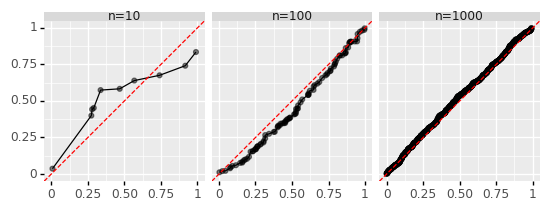

<ggplot: (336224609)>

In [4]:
p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y'), alpha=0.5)
p = p + geom_line(aes(x = 'x', y = 'y'))
p = p + facet_wrap(['label'])
p = p + coord_fixed(ratio = 1, xlim = [0,1])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + geom_abline(intercept = 0, slope = 1, color = 'red', linetype ='--')
display(p)

## II. Distribution of quantile-quantile plots

If the null hypothesis holds and both samples are taken from the same distribution, we get a distribution over functions of type $\mathrm{qq}:[0,1]\to[0,1]$. 
The simplest way to characterise this distribution is through simulation.
That is, we draw many sample pairs $x$ and $y$ from the same distribution and observe how the qq-plot looks like on average. As the fluctuations depend on the data distribution, we must fix a distribution before visualising the distribution of qq-lines.

###  Sampling procedure for the uniform distribution

In [5]:
sim = [None] * 100
for i in range(len(sim)):
    n = 10
    x = rnd.uniform(size=n)
    y = rnd.uniform(size=n)
    sim[i]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(run = i)

sim = pd.concat(sim, ignore_index=True)    

### Naive visualisation of the corresponding distribution of qq-lines

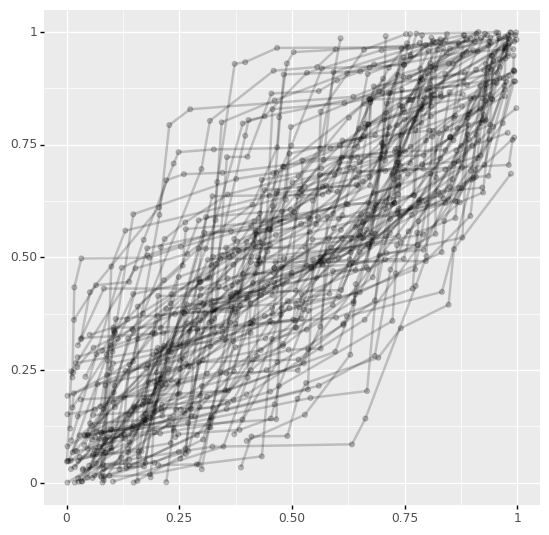

<ggplot: (339102163)>

In [6]:
p = ggplot(sim)
p = p + geom_point(aes(x = 'x', y = 'y'), alpha = 0.2 )
p = p + geom_line(aes(x = 'x', y = 'y', group ='run'), alpha = 0.2, size = 1)
p = p + coord_fixed(ratio = 1, xlim = [0,1])
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
display(p)
p.save('qq_line_distribution.pdf', path='results', height=6, width=6, verbose=False)

## III. Simulation-based confidence envelope for the quantile-quantile plot

The visualisation shown above is not very revealing as there is too much information to consider.
We can reduce the amount of information by considering the behavior of qq-lines $\mathrm{qq}(\cdot)$ at a fixed set of gridpoints $\xi_j$.
In particular, we can compute quantiles for the values $\mathrm{qq}(\xi_j)$. 
As the qq-line is a piece-wise linear function fixed by the observation pairs $(x_i, y_i)$, we need a linear interpolation routine 
[`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)
from `scipy` for evaluating $\mathrm{qq}(\xi_j)$.

### More thorough data gathering

We need more simulations to get precise enough quantile estimates – 100 samples are not enough to adequately fix $2.5\%$ and $97.5\%$ quantiles.

In [7]:
sim = [None] * 1000
for i in trange(len(sim)):
    n = 10
    x = rnd.uniform(size=n)
    y = rnd.uniform(size=n)
    sim[i]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(run = i)

sim = pd.concat(sim, ignore_index=True)  

  0%|          | 0/1000 [00:00<?, ?it/s]

### Example case for fixing the interpolation routine

Let's start from an example. Later, we'll extend it to define a function for tabulating the $\mathrm{qq}(\xi_j)$ values.

In [8]:
from scipy.interpolate import interp1d

In [9]:
# Fix the interpolation grid
xi = np.arange(0, 1.001, 0.05)

# Extract a single run for the experiment   
df = sim.loc[sim['run']==0, ['x', 'y']]

# Fix endpoints for complete interpolation
if df.iloc[0, 0] != 0:
    df = concat([DataFrame({'x': [0.0], 'y': [0.0]}), df], ignore_index=True)

if df.iloc[-1,0] != 1:
    df = concat([df, DataFrame({'x': [1.0], 'y': [1.0]})], ignore_index=True)
    
# Define interpolator and evalute it on the grid
interp1d(df['x'], df['y'])(xi)

array([0.        , 0.32171281, 0.34856554, 0.37541827, 0.40227099,
       0.46643616, 0.53758913, 0.56165427, 0.5651811 , 0.56870793,
       0.57863991, 0.59548997, 0.61234002, 0.62345315, 0.62695427,
       0.63039614, 0.63383801, 0.68701868, 0.83214474, 0.94828005,
       1.        ])

### Function for tabulating $\mathrm{qq}(\xi_i)$ values on the grid

In [10]:
def tabulate_qq(run: DataFrame, xi: np.array) -> DataFrame:
    """Uses linear interpolation to tabulate values of qq-line on a grid"""
    
    df = run[['x', 'y']].copy()
    
    # Fix endpoints for complete interpolation
    if df.iloc[0, 0] != 0:
        df = concat([DataFrame({'x': [0.0], 'y': [0.0]}), df], ignore_index=True)

    if df.iloc[-1,0] != 1:
        df = concat([df, DataFrame({'x': [1.0], 'y': [1.0]})], ignore_index=True)
    
    # Define interpolator and evalute it on the grid
    return DataFrame({'x': xi, 'y': interp1d(df['x'], df['y'])(xi)})    

Visual verification:

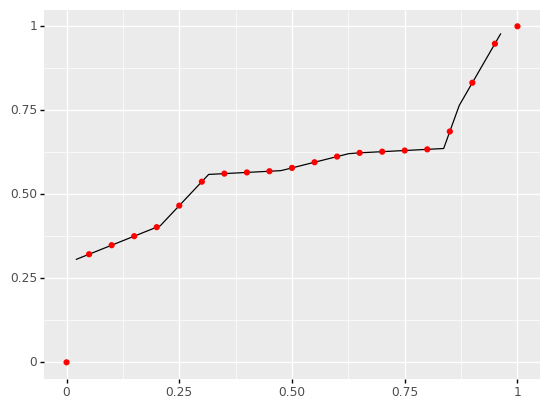

<ggplot: (336238764)>

In [11]:
run = sim.loc[sim['run']==0]
p = ggplot(tabulate_qq(run, xi = np.arange(0, 1.001, 0.05)))
p = p + geom_line(aes(x = 'x', y = 'y'), data = run)
p = p + geom_point(aes(x = 'x', y = 'y'), color = 'red')
p + scale_x_continuous(name = '') + scale_y_continuous(name = '')

### Tabulation of $\mathrm{qq}(\xi_i)$ values for the entire simulation

In [12]:
df = (sim.groupby('run').apply(tabulate_qq, xi)
      .reset_index('run')
      .reset_index(drop=True))
display(head(df))

,run,x,y
0,0,0.00,0.000000
1,0,0.05,0.321713
2,0,0.10,0.348566
3,0,0.15,0.375418
4,0,0.20,0.402271


### Quantile computation on tabulated values

In [13]:
result = (df[['x', 'y']].groupby('x')
          .aggregate('quantile', [0.025, 0.5, 0.975])
          .unstack()
          .pipe(reset_column_index, 0)
          .rename(columns = {0.025: 'q_025', 0.5: 'q_500', 0.975: 'q_975'})
          .reset_index())

head(result)

,x,q_025,q_500,q_975
0,0.00,0.000000,0.000000,0.000000
1,0.05,0.001734,0.049065,0.330920
2,0.10,0.004563,0.098316,0.455617
3,0.15,0.009260,0.149687,0.529704
4,0.20,0.014240,0.197749,0.591910


### Final visualisation of the resulting pointwise 90% confidence band

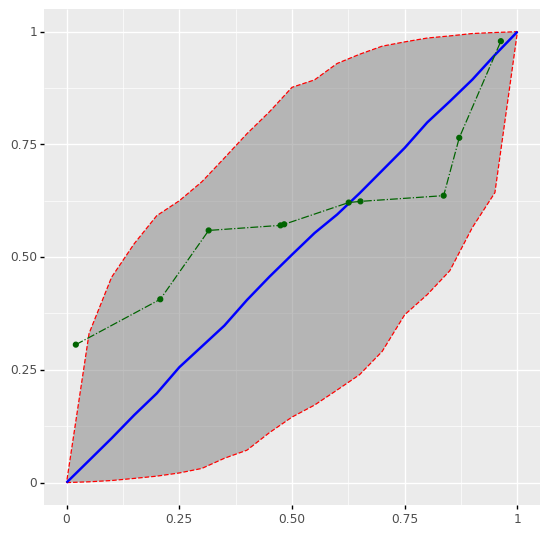

<ggplot: (339939503)>

In [14]:
run = sim.loc[sim['run']==0]

p = ggplot(result)
p = p + geom_ribbon(aes(x = 'x', ymin = 'q_025', ymax = 'q_975'), 
                        fill = 'gray', alpha = 0.5, color = 'red', linetype = '--')
p = p + geom_line(aes(x = 'x', y = 'q_500'), color = 'blue', size = 1)
p = p + geom_point(aes(x = 'x', y ='y'), data = run, color = 'darkgreen')
p = p + geom_line(aes(x = 'x', y ='y'), data = run, color = 'darkgreen', linetype='-.')
p = p + coord_fixed(ratio = 1, xlim = [0,1])
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
display(p)
p.save('qq_confidence_envelope.pdf', path='results', height=6, width=6, verbose=False)

# Homework

## 3. 1 Distribution of the qq-lines depends on the source  and sample size (<font color='red'>1p</font>)

So far, we computed the confidence envelope for a very specific case. As the fluctuations might depend on the data distribution and sample size, experiment with different distributions. Use uniform, normal and exponential distributions from `numpy.random` and take $100$ and $1000$ samples for $x$ and $y$.
For each setup, repeat the experiment 100 times and draw points defining the qq-lines on the same graph.
Experiment with different `alpha` (transparency) values to get the best representation. As a result, you should get three different fluctuation patterns. Interpret the results.

In [15]:
rnd.uniform(size=10)
rnd.normal(size=20)
rnd.exponential(size=20)

array([0.50416018, 0.33741806, 0.79632532, 0.39500294, 0.76026447,
       2.1024313 , 0.59554467, 0.43611027, 0.05932134, 0.03395634,
       0.25281674, 0.40854763, 0.73611233, 0.56379988, 0.59534956,
       0.83125112, 0.30653694, 3.55772911, 0.24769099, 0.84085362])

## 3.2 Confidence envelopes through simulations (<font color='red'>1p</font>)

If the distribution to compare with is known then the use of theoretical quantiles reduces the amount of noise in the graph. For instance, if we want to compare a sample vector $y$ of size $100$ with uniform distribution, we can set 
~~~~
x = scipy.stats.uniform().ppf(np.arrange(0, 1.0001, 0.01))
~~~~
to set theoretical quantiles on the $x$-axis. This gives a sightly simpler way to compute the confidence envelope:

*  Draw $1000$ sample vectors $y$ of size 100 for all distributions.
*  Compute desired empirical quantiles with `numpy.quantile` or `sort`
~~~~~
q = np.arange(0, 1.001, 0.01)
Q.iloc[i,:] = np.quantile(y, q = q)
~~~~~
   and store results into a row of a $1000\times 100$ matrix `Q`. 
 
* As a result, every column `Q.iloc[:,j]` represents individual measurements of a quantile `q[j]` and you can compute 2.5%, 50% and 97.5% empirical quantiles for each `q[j]`. 
  Using these values, draw the confidence envelopes on a separate plot for all three distributions.

Alternatively, you can construct the confidence envelope similarly to the way we constructed the envelope above with the exception that there is no need to use interpolation – all $\mathrm{qq}(\xi_j)$ values will correspond to some $y_i$. 

In [16]:
stats.uniform.ppf(np.arange(0, 1.001, 0.01))
stats.norm.ppf(np.arange(0, 1.001, 0.01))
stats.expon.ppf(np.arange(0, 1.001, 0.01))
pass

## 3.3 Theoretical confidence envelopes for the uniform distribution (<font color='red'>1p</font>)

In general, finding analytical confidence intervals for the qq-plot is intractable, unless you compare a sample against a known distribution with a simple enough cumulative distribution function.
In particular, there is a closed form solution for the uniform distribution over $[0,1]$.
Let $\boldsymbol{y}$ be an $n$ element i.i.d. (independent and uniformly distributed) sample from the uniform distribution.
If $\boldsymbol{z}\gets \mathrm{sort}(\boldsymbol{y})$ then its $k$-th element $z_k$ is distributed according to a beta distribution with parameters $k$ and $n+1-k$. Hence, for the uniform distribution we can provide analytical confidence intervals by solving the equations

\begin{align*}
     & \Pr[z_k\gets\mathcal{B}(k, n+1-k): z_k\leq \alpha]= 2.5\% \\
     & \Pr[z_k\gets\mathcal{B}(k, n+1-k): z_k\leq \beta]= 97.5\%
\end{align*}

for $\alpha$ and $\beta$. For that, you can use the function `scipy.stats.beta.ppf` with appropriate parameters. Draw the corresponding graph and compare with empirical results you obtained in the previous exercise. 
How many points of the qq-plot should lie outside of the confidence envelope if $\boldsymbol{y}$ is uniformly distributed?
Verify your quess with a few samples drawn on top of the confidence envelope.

In [17]:
stats.beta(1,3).ppf(np.arange(0, 1.001, 0.01))

array([0.        , 0.00334451, 0.00671161, 0.0101017 , 0.01351517,
       0.01695243, 0.02041389, 0.02389999, 0.02741117, 0.03094789,
       0.03451062, 0.03809983, 0.04171603, 0.04535973, 0.04903146,
       0.05273176, 0.0564612 , 0.06022036, 0.06400984, 0.06783025,
       0.07168223, 0.07556645, 0.07948359, 0.08343435, 0.08741947,
       0.0914397 , 0.09549583, 0.09958867, 0.10371905, 0.10788786,
       0.112096  , 0.11634441, 0.12063407, 0.12496599, 0.12934123,
       0.13376089, 0.13822612, 0.14273811, 0.1472981 , 0.15190739,
       0.15656733, 0.16127935, 0.16604491, 0.17086557, 0.17574294,
       0.18067873, 0.18567472, 0.19073277, 0.19585485, 0.20104303,
       0.20629947, 0.21162648, 0.21702647, 0.22250199, 0.22805574,
       0.23369057, 0.23940951, 0.24521577, 0.25111276, 0.25710412,
       0.2631937 , 0.26938564, 0.27568436, 0.28209456, 0.28862134,
       0.29527013, 0.3020468 , 0.30895768, 0.31600962, 0.32321005,
       0.33056705, 0.33808941, 0.34578674, 0.35366959, 0.36174

## 3.4  Confidence envelopes for unknown distributions using bootstrapping* (<font color='red'>3p</font>)

The methods sketched above work if at least one of the distributions is known. This is usually not the case in practice. One way to solve this issue is to use bootstrap samples from $\boldsymbol{x}$, allowing us to replicate computations done in the first part of the notebook. 

Note that we can do slightly better by using continuous bootstrapping that adds Gaussian noise to the bootstrap samples.
The original bootstrapping corresponds to sampling from the distribution that is defined by the raw histogram of $\boldsymbol{x}$. 
This might be quite a rough description of the distribution and introduce unwanted artefacts.
It is quite common to smooth the histogram using a Gaussian kernel to mitigate this issue. 

Adding Gaussian noise with the right standard deviation $\sigma$ makes it possible to do the kernel smoothing without explicitly computing the smoothed histogram.
[A rule-of-thumb bandwidth estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator) 
$\sigma = 1.06\hat{\sigma}n^{-1/5}$ would be sufficient for our purposes.

Based on the above, design an algorithm for computing confidence envelopes for two samples $\boldsymbol{x}$ and $\boldsymbol{y}$ without any knowledge about the data source:

* Implement the continuous bootstrap and draw many samples to verify that the resulting histogram is smoothed as expected.
* Compute a simulation-based confidence envelope with the continuous bootstrap.
* Compute a simulation-based confidence envelope with the standard bootstrap.
* Compare the confidence envelopes and interpret the results.

You may use samples from any distribution but it would make sense to consider uniform, normal or exponential distributions as we know how to generate precise confidence envelopes for these.

In [18]:
%config IPCompleter.greedy=True